# Distributed Computation and the Tao of Parsimony

**Definition**: Parsimony - extreme unwillingness to spend money or use resources.

My job, and my hobby, is thinking about how *computation* works. How do numbers flow through your computer, go through some arcane numeric witchery, and wind up doing exactly what you need them to do?

It helps to imagine a computer in the *same way* a famous science fiction novel does; in the book The Three Body Problem, by Cixin Liu, humanity builds a *computer* by using people holding flags to represent information.

Armies of people grouped together on a field waving flags can pretend (moderately well) to be a computation engine. Pretty neat.

One of the ways that large amounts of information were moved back and forth was by using a soldier on horseback (a *buffer*), to carry information from one group to another quickly.

You can't simply allow everyone to run around on horseback! It would be chaos and nothing would get done; everyone would be in the way.

That doesn't *quite* literally translate to modern computing, but the metaphor is solid.

You can imagine computation as interconnected *groups of people*; each group can perform a task. The groups are connected by wires and information can be sent down the wires, but only as fast as a person can talk. Additionally, the information the group holds is *written on stone tablets*; each person can only hold **literally** so much information. Also, the group is limited is to how quickly they can solve the problem.

These concepts have corollaries; *SerDe* (Serialization / Deserialization) refers to the actions taken to put information into, and pull things out of, a *buffer* which allows processes to exchange information. It takes time to *create an item* in the buffer and it takes time to *read* the item in the buffer.

There's an *information transfer speed limit*.

Each process is using compute from at least one of potentially many processors but is bound to the processing power available in the process (well, kind of, Spark and other distributed engines skirt this constraint.)

Each process requires holding the data it gets from the buffer, meaning that you could have two processes holding the *same information*. These processes potentially share the same resources and data exchanged between them will require both processes to each maintain a copy.

Inefficient.

But, good news awaits! Engineers have done their best to work around this problem in a way that lets you do what you need to do by using *no-copy*.



## What is No Copy?

Numpy, and PyArrow, are two *data container and computation* solutions which provide a high-level interface to low-level highly optimized and efficient computation.

Imagine that the group of people in the example above all maintain their stone tablets in *one place* and every group has a wire connecting it to that place. When one group is done with a job and they want to share the stone tablets they've made they *tell the other group where the tablets are*.

A reference to the location in memory of an array that PyArrow and / or Numpy are maintaining is what Numpy and PyArrow are handing back and forth, which allows them to transfer the *location* quickly without copying the data. Another process just slaps a Numpy / PyArrow sticker on that location and says 'look at how many bits can fit in that trunk'.

The information speed limit just got cranked *way* up.

*How* much gain was there?

Let's find out; I'm going to run an experiment below where I simulate *pulling information* out of a Ray cluster.

As long as the Ray storage location is on the same device Numpy gets the advantage of *no-copy* when Ray hands Numpy arrays around.

Does PyArrow get the same? What about just using a regular buffer? We'll simulate pulling Numpy, PyArrow, and List containers and see what the time and resource usage statistics look like.

Disclosure; this was run on a commodity laptop.

## Experimental Setup

Note that this is all *local*, meaning that this is a one-node cluster.

In [1]:
# Experiment Prerequisites
## Random number generation
import numpy.random as nr
## Pyarrow!
import pyarrow as pa
## Experiment tracking
import mlflow
## Remote computation
import ray
## Just used to help organize temporary output.
import tempfile
## Measurement
from guppy import hpy
## Measurment
import cProfile
## Measurement
import io
## Measurement
import pstats
## Visualization
import seaborn as sns

# Experiment Instantiation
## Tell MLFlow to use a local SQLite DB. Will be created if DNE.
mlflow.set_tracking_uri('sqlite:////experiments/experiments.db')
## Create a new experiment
mlflow.set_experiment('pyarrow-ray-01')
## Tell Numpy how to deal out pseudo-randomness.
rng = nr.default_rng(10)
## Turn on the Ray cluster.
ray.init()

2022-04-09 11:24:14,946	WARNING services.py:1909 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=0.90gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


{'node_ip_address': '172.17.0.2',
 'raylet_ip_address': '172.17.0.2',
 'redis_address': None,
 'object_store_address': '/tmp/ray/session_2022-04-09_11-24-13_821050_1765/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-04-09_11-24-13_821050_1765/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2022-04-09_11-24-13_821050_1765',
 'metrics_export_port': 50628,
 'gcs_address': '172.17.0.2:59219',
 'address': '172.17.0.2:59219',
 'node_id': 'a230bbbacfd40433cad2a3a11f80560b6ffbba64b803dc7004ed8483'}

## Experiment

This experiment simulates extracting significant amounts of data from the Ray cluster.

Various array sizes ($S$) are run through ten trials ($T\in(0, 9)$); in each trial an array of size $S$ is pulled $1000T$ times from the cluster. The RAM usage and the time for this trial are logged.

In [2]:
@ray.remote
def random_data(n):
    """Produce random data for testing."""
    return list(rng.random(n))

@ray.remote
def random_data_numpy(n):
    """Produce random data for testing."""
    return rng.random(n)

@ray.remote
def random_data_pyarrow(n):
    """Produce rand(om data for testing."""
    return pa.array(rng.random(n))

def trial(remote_data, m):
    """Estimate the length of time it takes to get a set of items out of a Ray cluster."""
    i = 0
    while i <= m:
        ray.get(remote_data)

## Run the experiment

In [4]:
# Let's get it on!
mlflow.set_experiment('pyarrow-ray-01')
# Start measurement of RAM usage
h = hpy()
# Declare the heap
x = h.heap()
# Loop through the sizes
with tempfile.TemporaryDirectory() as t:
    for array_size in [100, 1000, 10000, 100000]:
        print(f"Running experiment with array_size = {array_size}")
        # Start the experimental run
        for trial in range(10):
            with mlflow.start_run() as experiment_run:
                mlflow.log_param(key='array_size', value=array_size)
                print(f"Running trial = {trial}")
                mlflow.log_param(key='trial', value=trial)
                remote_data = {
                    'list': random_data.remote(array_size),
                    'numpy': random_data_numpy.remote(array_size),
                    'pyarrow': random_data_pyarrow.remote(array_size)
                }
                for key, value in remote_data.items():
                    print(f"Collecting data for = {key}")
                    def get_val():
                        for _ in range(trial * 1000):
                            _ = ray.get(value)
                    # Pre function call RAM usage:
                    size_0 = x.size
                    # Profile the function call
                    pr = cProfile.Profile()
                    pr.enable()
                    get_val()
                    pr.disable()
                    # Post function RAM usage.
                    s = io.StringIO()
                    ps = pstats.Stats(pr, stream=s)
                    mlflow.log_metric(key=f'time_{key}', value=ps.print_stats().total_tt)
                    mlflow.log_metric(key=f'ram_{key}', value=ps.print_stats().total_tt)
    

Running experiment with array_size = 100
Running trial = 0
Running trial = 1
Running trial = 2
Running trial = 3
Running trial = 4
Running trial = 5
Running trial = 6
Running trial = 7
Running trial = 8
Running trial = 9
Running experiment with array_size = 1000
Running trial = 0
Running trial = 1
Running trial = 2
Running trial = 3
Running trial = 4
Running trial = 5
Running trial = 6
Running trial = 7
Running trial = 8
Running trial = 9
Running experiment with array_size = 10000
Running trial = 0
Running trial = 1
Running trial = 2
Running trial = 3
Running trial = 4
Running trial = 5
Running trial = 6
Running trial = 7
Running trial = 8
Running trial = 9
Running experiment with array_size = 100000
Running trial = 0
Running trial = 1
Running trial = 2
Running trial = 3
Running trial = 4
Running trial = 5
Running trial = 6
Running trial = 7
Running trial = 8
Running trial = 9


## Unpack the results

Here we're going to unpack the information!

In [2]:
from mlflow import search_runs
df_results = search_runs()

In [3]:
df_results = df_results[['metrics.time_pyarrow', 'metrics.time_numpy', 'metrics.time_list', 'metrics.ram_pyarrow', 'metrics.ram_numpy', 'metrics.ram_list', 'params.array_size', 'params.trial']]

In [4]:
df_results.head()


,metrics.time_pyarrow,metrics.time_numpy,metrics.time_list,metrics.ram_pyarrow,metrics.ram_numpy,metrics.ram_list,params.array_size,params.trial
0,3.127627,3.000348,611.496308,3.127627,3.000348,611.496308,100000,9
1,2.595407,2.448557,604.117492,2.595407,2.448557,604.117492,100000,8
2,2.916762,2.924818,561.058394,2.916762,2.924818,561.058394,100000,7
3,1.874686,1.515688,400.770934,1.874686,1.515688,400.770934,100000,6
4,1.321852,1.304269,333.754422,1.321852,1.304269,333.754422,100000,5


### Computation Time Profiling

This section lays out two plots; the first just helps understand how long it takes to get regular items in and out of the buffer in this experiment by **just showing List item** times. The second picture contrasts the time by representing the PyArrow and Numpy time as a *fraction* of the time that a List took.

What do these pictures illustrate?

1. Putting lists into and pulling them out from a remote storage by copying them into and out of a buffer is dumb. Don't do it. Note the log scale on the illustration and how the lines appear to be uniformly separated? The array sizes increas as powers of 10 and so we can use the picture to illustrate that this the retrieval time is *linearly proportional to the size of the array* (there are better ways of showing this, but this plot helps uniformly separate the lines.) Basically $t_{transfer}=aS$ where $a$ is some undefined *constant* and $S$ is the size of the array.
2. Numpy and PyArrow both get about the same amount of *performance gain* w.r.t. copying data into and out of the buffer.

Boom!

Now when we build distributed computation engines we can use Numpy and PyArrow data structures.

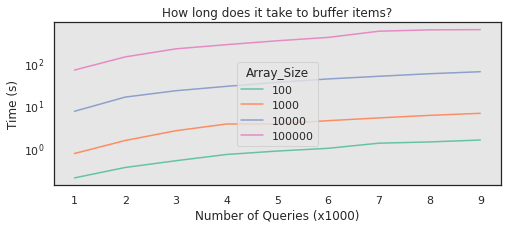

In [60]:
import matplotlib.pyplot as plt
sns.set_style('white', {"axes.facecolor": ".9"})
sns.set_context('notebook')
ax = sns.lineplot(
    x='params.trial',
    y="metrics.time_list",
    hue='params.array_size',
    data=df_results.astype({'params.array_size':'int', 'params.trial':'int'}).query('`params.trial`>0'),
    palette="Set2"
)
ax.set_xlabel("Number of Queries (x1000)")
ax.set_ylabel("Time (s)")
ax.set_yscale("log")
ax.set_title("How long does it take to buffer items?")
plt.legend(title='Array_Size', loc='center')
sns.set(rc = {'figure.figsize':(8,3)})

As a fair word of warning this plot could be mildly deceptive; the only information that you should take from it is that the distribution of times for both PyArrow and Numpy item retrieval are kind of hand-wavy approximately equal.

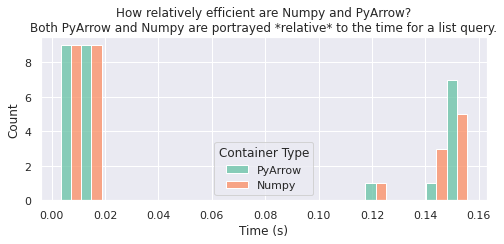

In [76]:
ax = sns.histplot(
    x='Time',
    hue='Container Type',
    data=df_results.eval(
            'PyArrow=`metrics.time_pyarrow`/`metrics.time_list`'
        ).eval(
            'Numpy=`metrics.time_numpy`/`metrics.time_list`'
        ).melt(
            id_vars=['params.array_size', 'params.trial'],
            value_vars=['PyArrow', 'Numpy'],
            var_name='Container Type',
            value_name='Time'
        ).astype({'params.array_size':'int', 'params.trial':'int'}).query('`params.trial`>0 and `params.array_size`>100'),
    palette="Set2",
    multiple='dodge',
    bins=20
)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Count")
ax.set_title("""How relatively efficient are Numpy and PyArrow?
Both PyArrow and Numpy are portrayed *relative* to the time for a list query.""")
sns.set(rc = {'figure.figsize':(8,3)})